## Percobaan untuk Mengelompokkan Warna berdasarkan Musim
## Menggunakan DecisionTreeClassifier
## Dengan dataset ('colorhexa_com.csv')

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier

## Data Collection + Data Preprocessing
### Load Data

In [2]:
#muat dataset colors
colors_df = pd.read_csv('colorhexa_com.csv')
colors_df.info()
colors_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           746 non-null    object 
 1   Hex (24 bit)   746 non-null    object 
 2   Red (8 bit)    746 non-null    int64  
 3   Green (8 bit)  746 non-null    int64  
 4   Blue (8 bit)   746 non-null    int64  
 5   Hue (degrees)  746 non-null    float64
 6   HSL.S (%)      746 non-null    float64
 7   HSL.L (%)      746 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 46.8+ KB


,Name,Hex (24 bit),Red (8 bit),Green (8 bit),Blue (8 bit),Hue (degrees),HSL.S (%),HSL.L (%)
0,Air Force blue,#5d8aa8,93,138,168,204.0,30.1,51.2
1,Alice blue,#f0f8ff,240,248,255,208.0,100.0,97.1
2,Alizarin crimson,#e32636,227,38,54,354.9,77.1,52.0
3,Almond,#efdecd,239,222,205,30.0,51.5,87.1
4,Amaranth,#e52b50,229,43,80,348.1,78.2,53.3


## Feature Engineering

Mengkategorikan warna berdasarkan nilai RGB, Hue, HSL.S, dan HSL.L ke dalam 'Season'

In [3]:
def categorize_color_by_season(row):
    """
    Mengkategorikan warna berdasarkan nilai RGB, Hue, HSL.S, dan HSL.L ke dalam musim.

    Args:
    row (pd.Series): Baris dari DataFrame yang berisi nilai RGB, Hue, HSL.S, dan HSL.L.

    Returns:
    str: Kategori musim dari warna (Spring, Summer, Autumn, Winter).
    """
    r, g, b = row['Red (8 bit)'], row['Green (8 bit)'], row['Blue (8 bit)']
    hue = row['Hue (degrees)']
    saturation = row['HSL.S (%)']
    lightness = row['HSL.L (%)']
    
    # Menghitung kecerahan (brightness)
    brightness = (r + g + b) / 3
    
    # Menghitung kehangatan (warmth)
    warmth = r - b
    
    if lightness > 70:  # Warna terang
        if warmth > 20 and saturation > 50:
            return 'Spring'
        elif saturation < 50:
            return 'Summer'
    else:  # Warna gelap
        if warmth < -20 and saturation > 50:
            return 'Winter'
        elif warmth > 20:
            return 'Autumn'
    
    return 'Uncategorized'

### Hasil Pemberian Kategori Warna Berdasarkan 'Season'

In [4]:
# Apply the function to categorize colors
colors_df['Season'] = colors_df.apply(categorize_color_by_season, axis=1)
colors_df.head(10)

,Name,Hex (24 bit),Red (8 bit),Green (8 bit),Blue (8 bit),Hue (degrees),HSL.S (%),HSL.L (%),Season
0,Air Force blue,#5d8aa8,93,138,168,204.0,30.1,51.2,Uncategorized
1,Alice blue,#f0f8ff,240,248,255,208.0,100.0,97.1,Uncategorized
2,Alizarin crimson,#e32636,227,38,54,354.9,77.1,52.0,Autumn
3,Almond,#efdecd,239,222,205,30.0,51.5,87.1,Spring
4,Amaranth,#e52b50,229,43,80,348.1,78.2,53.3,Autumn
5,Amber,#ffbf00,255,191,0,44.9,100.0,50.0,Autumn
6,American rose,#ff033e,255,3,62,346.0,100.0,50.6,Autumn
7,Amethyst,#9966cc,153,102,204,270.0,50.0,60.0,Uncategorized
8,Android Green,#a4c639,164,198,57,74.5,55.3,50.0,Autumn
9,Anti-flash white,#f2f3f4,242,243,244,210.0,8.3,95.3,Summer


In [5]:
# Menghitung jumlah data untuk setiap kategori musim
season_counts = colors_df['Season'].value_counts()
season_counts

Season
Autumn           337
Uncategorized    165
Winter           134
Spring            76
Summer            34
Name: count, dtype: int64

### Hasil ploting warna berdasarkan kategori sudah menunjukkan pengelompokkan yang sesuai, ini berarti pola/pattern/rumus yang digunakan sudah mendekati sesuai dengan teori yang didapatkan

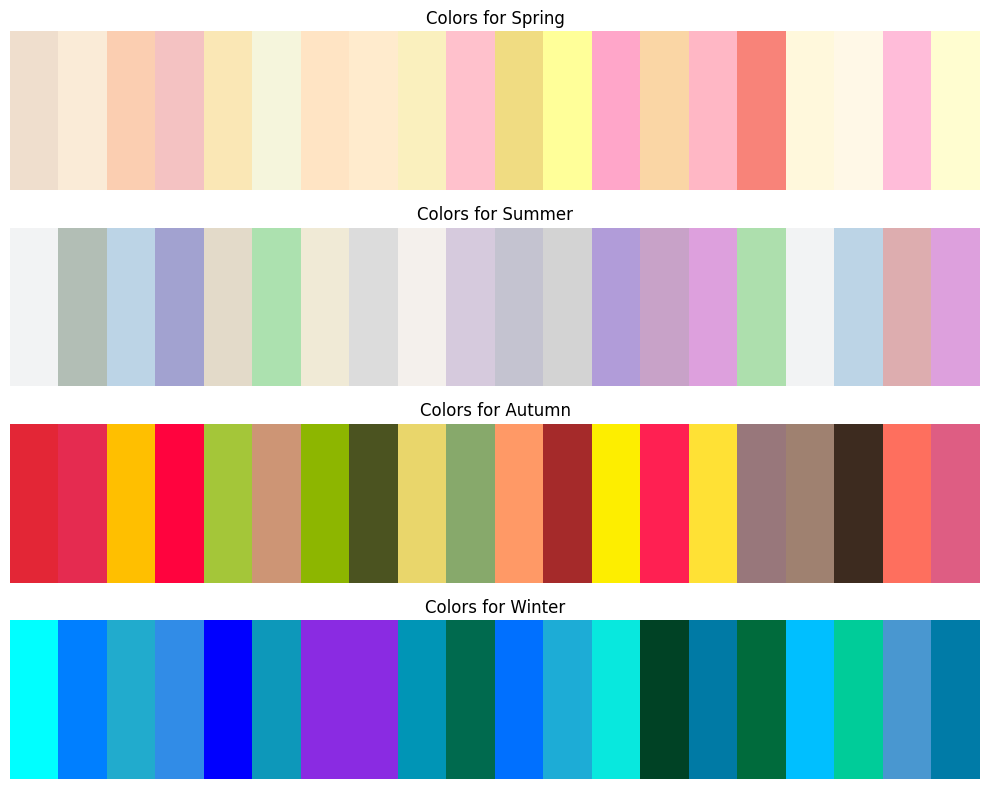

In [6]:
# Function to convert RGB values from 0-255 to 0-1 range
def rgb_to_mpl_color(rgb):
    return (rgb[0] / 255, rgb[1] / 255, rgb[2] / 255)

# Sample colors for each season
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
colors_per_season = {season: [] for season in seasons}

# Populate colors_per_season with the actual RGB values
for season in seasons:
    season_colors = colors_df[colors_df['Season'] == season].head(20)[['Red (8 bit)', 'Green (8 bit)', 'Blue (8 bit)']].values
    colors_per_season[season] = [rgb_to_mpl_color(color) for color in season_colors]

# Plot the colors
fig, axes = plt.subplots(4, 1, figsize=(10, 8))

for ax, season in zip(axes, seasons):
    ax.imshow([colors_per_season[season]], aspect='auto')
    ax.set_title(f'Colors for {season}')
    ax.axis('off')

plt.tight_layout()
plt.show()


Berikut adalah link yang memuat teori pengelompokkan warna yang coba saya implementasikan pada project ini https://digitalcommons.aaru.edu.jo/faa-design/vol11/iss1/50/

### Data dari dataset menunjukkan masih ada banyak warna yang dikategorikan sebagai 'Uncategorized'

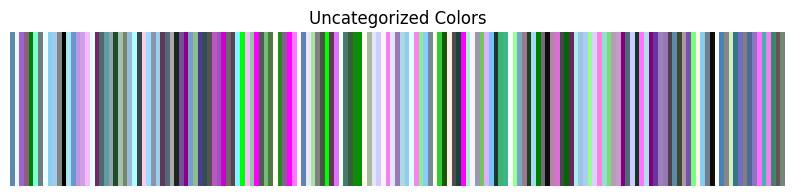

In [7]:
# Filter the data to get only the uncategorized colors
uncategorized_data = colors_df[colors_df['Season'] == 'Uncategorized']

# Function to convert RGB values from 0-255 to 0-1 range
def rgb_to_mpl_color(rgb):
    return (rgb[0] / 255, rgb[1] / 255, rgb[2] / 255)

# Get the RGB values of the uncategorized colors
uncategorized_colors = uncategorized_data[['Red (8 bit)', 'Green (8 bit)', 'Blue (8 bit)']].values
uncategorized_colors = [rgb_to_mpl_color(color) for color in uncategorized_colors]

# Plot the uncategorized colors
plt.figure(figsize=(10, 2))
plt.imshow([uncategorized_colors], aspect='auto')
plt.title('Uncategorized Colors')
plt.axis('off')
plt.show()

Dari warna yang 'Uncategorized' ini sebenarnya memiliki kesamaan yang menurut saya pribadi memang terlihat tidak masuk ke dalam kategori warna berdasarkan pola 'Season' yang telah ditentukan, namun hal ini masih perlu dicari celahnya ada dimana, apakah perlu disesuaikan kembali rumus penentuan 'Season'-nya atau bagaimana, agar dapat mengurangi jumlah warna yang masuk ke dalam kategori 'Uncategorized' ini.

In [8]:
new_colors_df = colors_df[colors_df['Season'] != 'Uncategorized']
# Check the distribution of categories
new_colors_df.head(10)

,Name,Hex (24 bit),Red (8 bit),Green (8 bit),Blue (8 bit),Hue (degrees),HSL.S (%),HSL.L (%),Season
2,Alizarin crimson,#e32636,227,38,54,354.9,77.1,52.0,Autumn
3,Almond,#efdecd,239,222,205,30.0,51.5,87.1,Spring
4,Amaranth,#e52b50,229,43,80,348.1,78.2,53.3,Autumn
5,Amber,#ffbf00,255,191,0,44.9,100.0,50.0,Autumn
6,American rose,#ff033e,255,3,62,346.0,100.0,50.6,Autumn
8,Android Green,#a4c639,164,198,57,74.5,55.3,50.0,Autumn
9,Anti-flash white,#f2f3f4,242,243,244,210.0,8.3,95.3,Summer
10,Antique brass,#cd9575,205,149,117,21.8,46.8,63.1,Autumn
12,Antique white,#faebd7,250,235,215,34.3,77.8,91.2,Spring
14,Apple green,#8db600,141,182,0,73.5,100.0,35.7,Autumn


In [9]:
le = LabelEncoder()
new_colors_df['Season_encoded'] = le.fit_transform(new_colors_df['Season'])
new_colors_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 581 entries, 2 to 745
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            581 non-null    object 
 1   Hex (24 bit)    581 non-null    object 
 2   Red (8 bit)     581 non-null    int64  
 3   Green (8 bit)   581 non-null    int64  
 4   Blue (8 bit)    581 non-null    int64  
 5   Hue (degrees)   581 non-null    float64
 6   HSL.S (%)       581 non-null    float64
 7   HSL.L (%)       581 non-null    float64
 8   Season          581 non-null    object 
 9   Season_encoded  581 non-null    int32  
dtypes: float64(3), int32(1), int64(3), object(3)
memory usage: 47.7+ KB


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11496\3302104235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_colors_df['Season_encoded'] = le.fit_transform(new_colors_df['Season'])


## Model Training

In [10]:
# Data preparation
X = new_colors_df[['Red (8 bit)', 'Green (8 bit)', 'Blue (8 bit)', 'Hue (degrees)', 'HSL.S (%)', 'HSL.L (%)']]
y = new_colors_df['Season']

In [11]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Train the model
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

## Model Evaluation

In [13]:
# Make predictions
y_pred = clf.predict(X_test)

In [14]:
# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Autumn       1.00      1.00      1.00       111
      Spring       1.00      1.00      1.00        21
      Summer       1.00      1.00      1.00         8
      Winter       1.00      1.00      1.00        35

    accuracy                           1.00       175
   macro avg       1.00      1.00      1.00       175
weighted avg       1.00      1.00      1.00       175



### Visualisasi penyebaran jumlah warna berdasarkan 'Season'

C:\Users\lenovo\AppData\Local\Temp\ipykernel_11496\1085911565.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=new_colors_df, x='Season',


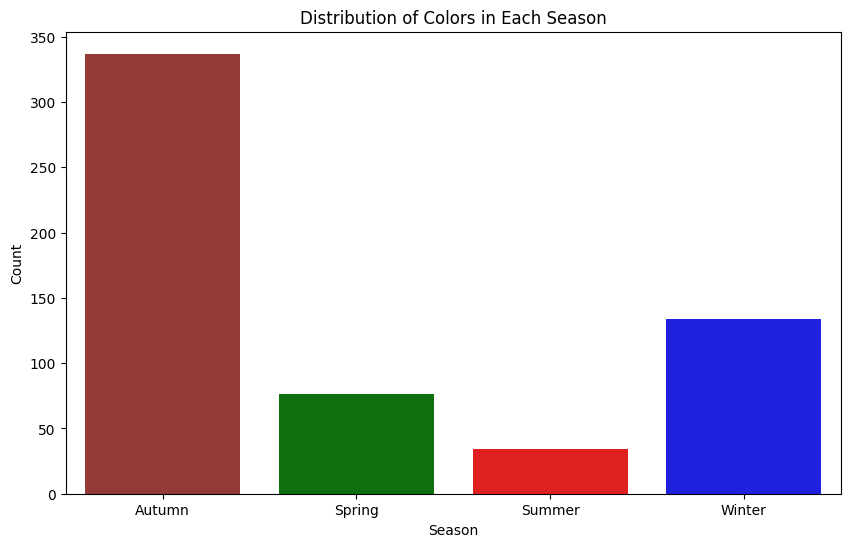

In [15]:
# Visualization Bar Chart
plt.figure(figsize=(10, 6))
sns.countplot(data=new_colors_df, x='Season', 
              palette={'Spring': 'green', 'Summer': 'red', 'Autumn': 'brown', 'Winter': 'blue'})
plt.title('Distribution of Colors in Each Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()

dapat diketahui ternyata berdasarkan pola/pattern yang telah dibuat serta data warna dari dataset yang digunakan, banyak dari warna tersebut yang dikategorikan sebagai warna 'Autumn'

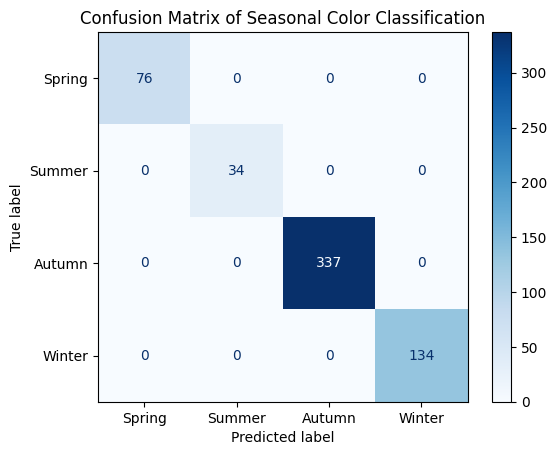

In [16]:
# Filter out Uncategorized values for better matrix visualization
filtered_data = new_colors_df[new_colors_df['Season'] != 'Uncategorized']

# Since there's no ground truth, we'll compare the predicted values to themselves
true_labels = filtered_data['Season']
predicted_labels = filtered_data['Season']

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Spring', 'Summer', 'Autumn', 'Winter'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Spring', 'Summer', 'Autumn', 'Winter'])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Seasonal Color Classification')
plt.show()


## Melakukan Cross Validation

In [17]:
# Assume X and y are the features and target variable
X = new_colors_df[['Red (8 bit)', 'Green (8 bit)', 'Blue (8 bit)', 'Hue (degrees)', 'HSL.S (%)', 'HSL.L (%)']]
y = new_colors_df['Season_encoded']

In [18]:
# Use a Ridge Regression model with L2 regularization
model = Ridge(alpha=1.0)  # Adjust alpha as needed

In [19]:
# Use K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf)

In [20]:
print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Cross-Validation Scores: [0.80817263 0.76382575 0.81663908 0.80043929 0.7535868 ]
Mean Cross-Validation Score: 0.7885327092192822


In [21]:
# For decision tree classifier with pruning
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)  # Adjust max_depth as needed
tree_scores = cross_val_score(tree_model, X, y, cv=kf)

In [22]:
print(f'Cross-Validation Scores for Decision Tree: {tree_scores}')
print(f'Mean Cross-Validation Score for Decision Tree: {tree_scores.mean()}')

Cross-Validation Scores for Decision Tree: [0.99145299 0.98275862 0.99137931 1.         0.97413793]
Mean Cross-Validation Score for Decision Tree: 0.9879457707043915


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11496\1712777366.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_colors_df['True_Season'] = true_seasons


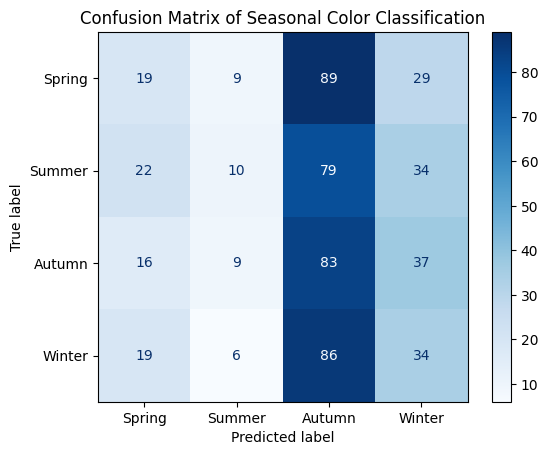

Spring:
  True Positive (TP): 19
  False Positive (FP): 57
  True Negative (TN): 378
  False Negative (FN): 127

Summer:
  True Positive (TP): 10
  False Positive (FP): 24
  True Negative (TN): 412
  False Negative (FN): 135

Autumn:
  True Positive (TP): 83
  False Positive (FP): 254
  True Negative (TN): 182
  False Negative (FN): 62

Winter:
  True Positive (TP): 34
  False Positive (FP): 100
  True Negative (TN): 336
  False Negative (FN): 111



In [23]:
num_samples = len(new_colors_df)
true_seasons = ['Spring', 'Summer', 'Autumn', 'Winter'] * (num_samples // 4)
true_seasons += ['Spring', 'Summer', 'Autumn', 'Winter'][:num_samples % 4]  # Ensure it matches the length of the DataFrame
new_colors_df['True_Season'] = true_seasons

# Filter out Uncategorized values for better matrix visualization
filtered_data = new_colors_df[new_colors_df['Season'] != 'Uncategorized']

# Get the true labels and predicted labels
true_labels = filtered_data['True_Season']
predicted_labels = filtered_data['Season']

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Spring', 'Summer', 'Autumn', 'Winter'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Spring', 'Summer', 'Autumn', 'Winter'])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Seasonal Color Classification')
plt.show()

# Calculate TP, FP, TN, FN
def calculate_tp_fp_tn_fn(conf_matrix):
    TP = np.diag(conf_matrix)
    FP = conf_matrix.sum(axis=0) - TP
    FN = conf_matrix.sum(axis=1) - TP
    TN = conf_matrix.sum() - (FP + FN + TP)
    return TP, FP, TN, FN

TP, FP, TN, FN = calculate_tp_fp_tn_fn(conf_matrix)

# Print the values
labels = ['Spring', 'Summer', 'Autumn', 'Winter']
for i, label in enumerate(labels):
    print(f"{label}:")
    print(f"  True Positive (TP): {TP[i]}")
    print(f"  False Positive (FP): {FP[i]}")
    print(f"  True Negative (TN): {TN[i]}")
    print(f"  False Negative (FN): {FN[i]}")
    print()